<a href="https://colab.research.google.com/github/Prachisoni07/ml/blob/main/classificationImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision timm opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

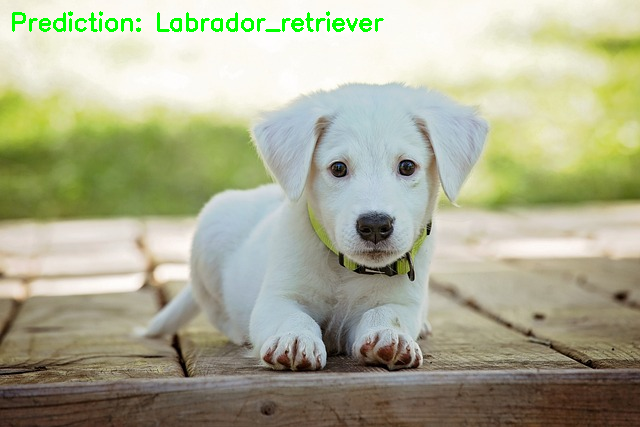

In [11]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import timm
import requests
import json
from pathlib import Path
from google.colab.patches import cv2_imshow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=1000)
model.eval().to(device)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess_image(img_path: str) -> torch.Tensor:
    """ Load and preprocess an image using OpenCV. """
    img_path = Path(img_path)
    if not img_path.exists():
        raise FileNotFoundError(f"Image not found: {img_path}")

    image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image: {img_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0).to(device)
    return image

def load_imagenet_labels():

    labels_url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    try:
        response = requests.get(labels_url)
        response.raise_for_status()
        labels = response.json()
        return [labels[str(i)][1] for i in range(1000)]
    except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
        print(f"Error loading ImageNet labels: {e}")
        return ["Unknown"] * 1000

imagenet_classes = load_imagenet_labels()

def predict_image(image_path: str) -> str:
    image = preprocess_image(image_path)

    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)

    return imagenet_classes[predicted.item()]

def display_prediction(image_path: str, predicted_class: str):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to display image {image_path}")
        return

    cv2.putText(image, f"Prediction: {predicted_class}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


image_path = "/content/puppy-1903313_640.jpg"
predicted_class = predict_image(image_path)
display_prediction(image_path, predicted_class)
